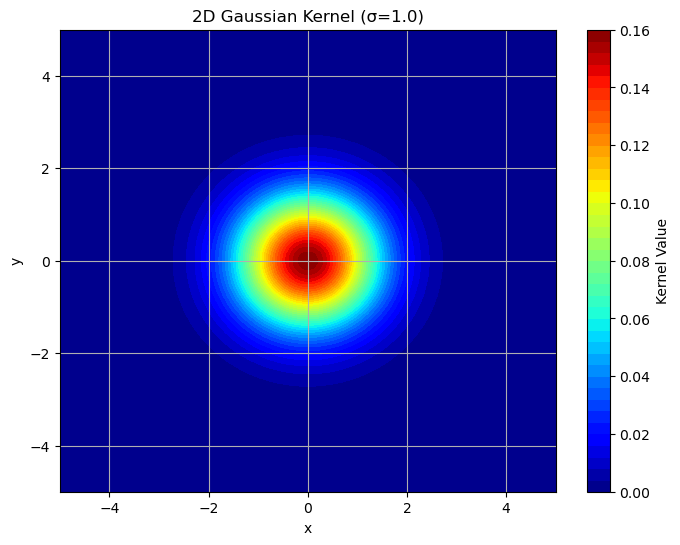

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def gaussian_kernel_2d(x, y, sigma):
    """Generate a 2D Gaussian kernel."""
    coeff = 1.0 / (2.0 * np.pi * sigma**2)
    exponent = -0.5 * (x**2 + y**2) / (sigma**2)
    return coeff * np.exp(exponent)

# Parameters
sigma = 1.0  # Standard deviation
size = 5 * sigma  # Size of the kernel
resolution = 100  # Resolution of the grid

# Create a grid of (x, y) coordinates
x = np.linspace(-size, size, resolution)
y = np.linspace(-size, size, resolution)
X, Y = np.meshgrid(x, y)

# Compute the Gaussian kernel
kernel = gaussian_kernel_2d(X, Y, sigma)

# Plot the Gaussian kernel
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, kernel, levels=50, cmap='jet')
plt.colorbar(label='Kernel Value')
plt.title(f'2D Gaussian Kernel (σ={sigma})')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()


Integral of the Gaussian kernel for dx=0.025: 1.0
Integral of the Gaussian kernel for dx=0.05: 1.0
Integral of the Gaussian kernel for dx=0.075: 1.0
Integral of the Gaussian kernel for dx=0.1: 1.0000000000000002
Integral of the Gaussian kernel for dx=0.15: 0.9999999999999999


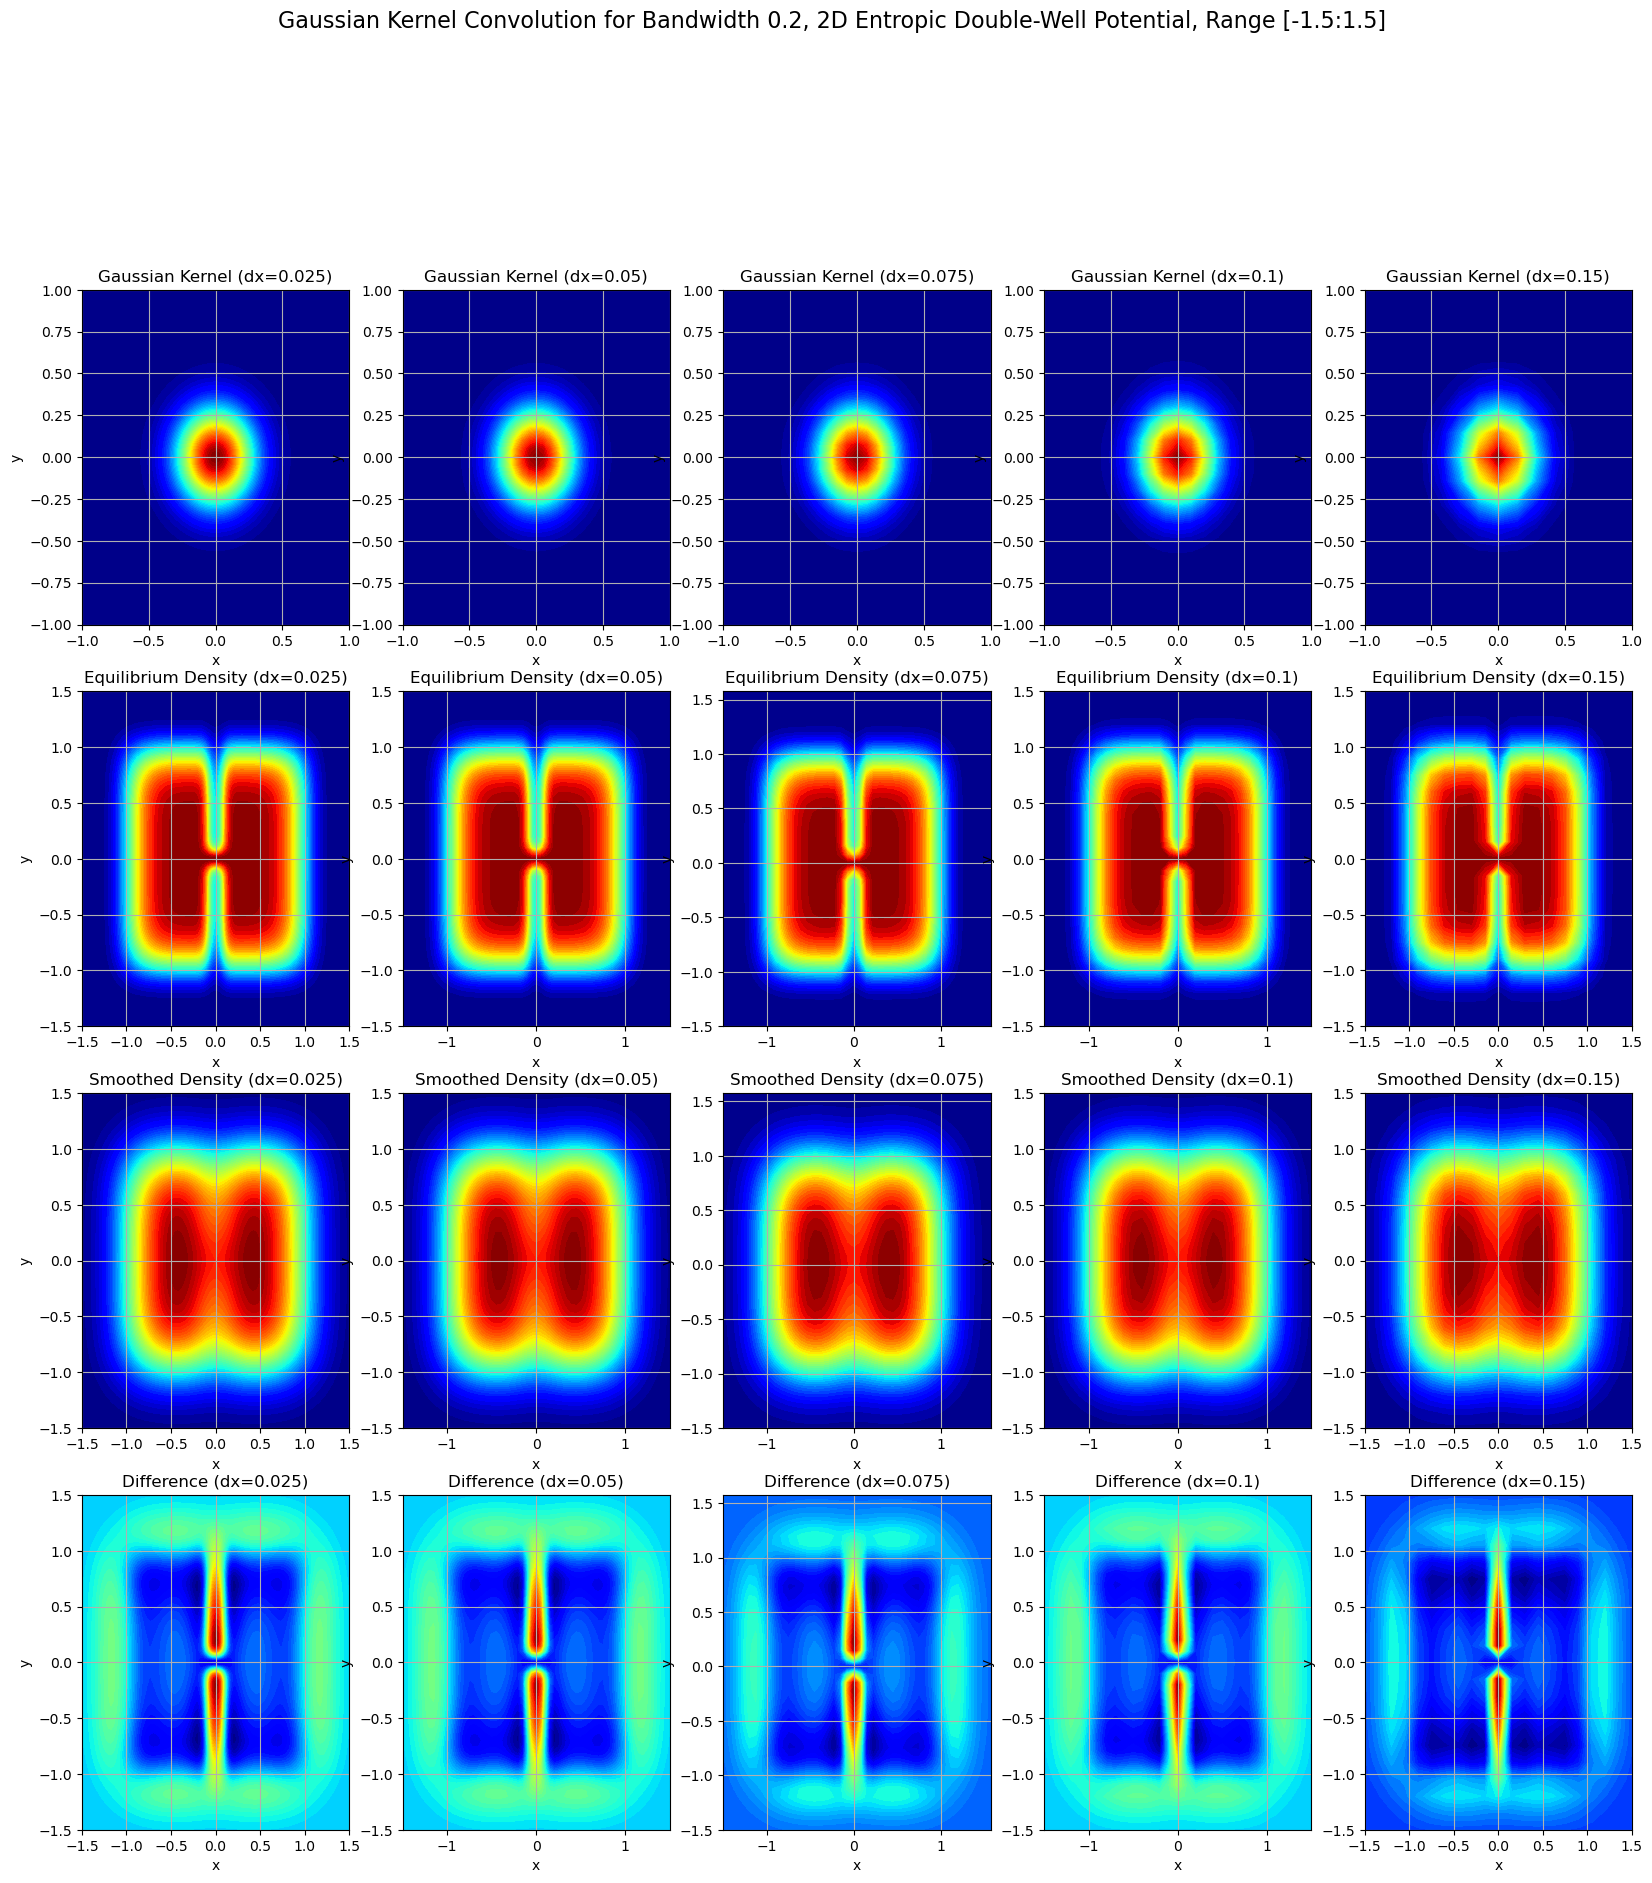

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# 2D Entropic Double-Well Potential Function


def V(x, y, sigma_x=0.1, sigma_y=0.1, a=1.0):
    return a * (x**6 + y**6 + np.exp(-(x/sigma_x)**2) * (1 - np.exp(-(y/sigma_y)**2)))



def gaussian_kernel_2d(x, y, sigma_kernel):
    coeff = 1.0 / (2.0 * np.pi * sigma_kernel**2)
    exponent = -0.5 * (x**2 + y**2) / (sigma_kernel**2)
    return coeff * np.exp(exponent)

def convolve_density_2d(boltz_array, kernel_array, dx, dy):
    """Perform 2D convolution on the density array manually."""
    boltz_array_conv = np.zeros_like(boltz_array)
    kernel_half_x = (kernel_array.shape[0] - 1) // 2
    kernel_half_y = (kernel_array.shape[1] - 1) // 2
    
    
    
     # Iterate over each pixel in the boltz_array
    for i in range(boltz_array.shape[0]):
        for j in range(boltz_array.shape[1]):
            
             # Iterate over each pixel in the kernel
            for m in range(kernel_array.shape[0]):
                for n in range(kernel_array.shape[1]):
                    i_shift = i - kernel_half_x + m
                    j_shift = j - kernel_half_y + n
                    
                    # Check if the shifted position is within the bounds
                    if 0 <= i_shift < boltz_array.shape[0] and 0 <= j_shift < boltz_array.shape[1]:
                        boltz_array_conv[i_shift, j_shift] += boltz_array[i, j] * kernel_array[m, n] * dx * dy
    
    return boltz_array_conv

def plot_results_2d(lattice_spacings, sigma_kernel, x_min, x_max, y_min, y_max):
    num_plots = len(lattice_spacings)
    fig, axs = plt.subplots(4, num_plots, figsize=(20, 20))
    
    
      # Set the figure background color to white
    fig.patch.set_facecolor('white')
    
    # Set the background color of all axes to white
    for ax in axs.flat:
        ax.set_facecolor('white')

    for i, dx in enumerate(lattice_spacings):
        dy = dx  # Assuming square grid
        x = np.arange(x_min, x_max + dx, dx)
        y = np.arange(y_min, y_max + dy, dy)
        X, Y = np.meshgrid(x, y)
        potential_array = V(X, Y)
        boltz_array = np.exp(-potential_array)
        
        # Normalize the Boltzmann density
        boltz_array /= np.trapz(np.trapz(boltz_array, y, axis=0), x, axis=0)
        
        # Kernel and its convolution
        kernel_size = int(5 * sigma_kernel)  # Approximate size
        npoints_kernel_x = int((kernel_size - 0.1 * dx) / dx) + 1
        npoints_kernel_x = 2 * npoints_kernel_x + 1  # Ensure odd number
        kernel_x = np.linspace(-kernel_size, kernel_size, npoints_kernel_x)
        
        npoints_kernel_y = int((kernel_size - 0.1 * dy) / dy) + 1
        npoints_kernel_y = 2 * npoints_kernel_y + 1  # Ensure odd number
        kernel_y = np.linspace(-kernel_size, kernel_size, npoints_kernel_y)
        
        Kernel_X, Kernel_Y = np.meshgrid(kernel_x, kernel_y)
        kernel_array = gaussian_kernel_2d(Kernel_X, Kernel_Y, sigma_kernel)
        
        # Normalize the kernel using trapezium rule
        kernel_integral = np.trapz(np.trapz(kernel_array, kernel_y, axis=0), kernel_x, axis=0)
        kernel_array /= kernel_integral
        
        # Print the integral of the kernel to check if it is equal to one
        print(f'Integral of the Gaussian kernel for dx={dx}: {np.trapz(np.trapz(kernel_array, kernel_y, axis=0), kernel_x, axis=0)}')
        
        boltz_array_conv = convolve_density_2d(boltz_array, kernel_array, dx, dy)
        
        # Calculate potential from convolved density
        with np.errstate(divide='ignore'):
            potential_array_conv = -np.log(boltz_array_conv)
        
        # Plot Gaussian Kernel
        axs[0, i].contourf(Kernel_X, Kernel_Y, kernel_array, levels=50, cmap='jet')
        axs[0, i].set_xlabel('x')
        axs[0, i].set_ylabel('y')
        axs[0, i].set_title(f'Gaussian Kernel (dx={dx})')
        axs[0, i].grid(True)
        
        # Plot Equilibrium Density
        axs[1, i].contourf(X, Y, boltz_array, levels=50, cmap='jet')
        axs[1, i].set_xlabel('x')
        axs[1, i].set_ylabel('y')
        axs[1, i].set_title(f'Equilibrium Density (dx={dx})')
        axs[1, i].grid(True)
        
        # Plot Smoothed Density
        axs[2, i].contourf(X, Y, boltz_array_conv, levels=50, cmap='jet')
        axs[2, i].set_xlabel('x')
        axs[2, i].set_ylabel('y')
        axs[2, i].set_title(f'Smoothed Density (dx={dx})')
        axs[2, i].grid(True)
        
        # Compute and Plot Difference between Densities
        density_difference = boltz_array_conv - boltz_array
        axs[3, i].contourf(X, Y, density_difference, levels=50, cmap='jet')
        axs[3, i].set_xlabel('x')
        axs[3, i].set_ylabel('y')
        axs[3, i].set_title(f'Difference (dx={dx})')
        axs[3, i].grid(True)
        
        
     # Add a main title to the figure     
    fig.suptitle('Gaussian Kernel Convolution for Bandwidth 0.2, 2D Entropic Double-Well Potential, Range [-1.5:1.5]', fontsize=16, y=1.02)
     # Adjust layout and save the plotplt.tight_layout()
    plt.savefig('GK_2d_jet_bwo2.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

if __name__ == "__main__":
    lattice_spacings = [0.025, 0.05, 0.075, 0.1, 0.15]  # Finer lattice spacings for 2D
    sigma_kernel = 0.2  # Fixed bandwidth for Gaussian kernel
    x_min, x_max = -1.5, 1.5  # Range in x direction
    y_min, y_max = -1.5, 1.5  # Range in y direction
    plot_results_2d(lattice_spacings, sigma_kernel, x_min, x_max, y_min, y_max)


Integral of the Gaussian kernel for dx=0.025: 1.0
Integral of the Gaussian kernel for dx=0.05: 0.9999999999999998
Integral of the Gaussian kernel for dx=0.075: 0.9999999999999999
Integral of the Gaussian kernel for dx=0.1: 1.0
Integral of the Gaussian kernel for dx=0.15: 1.0


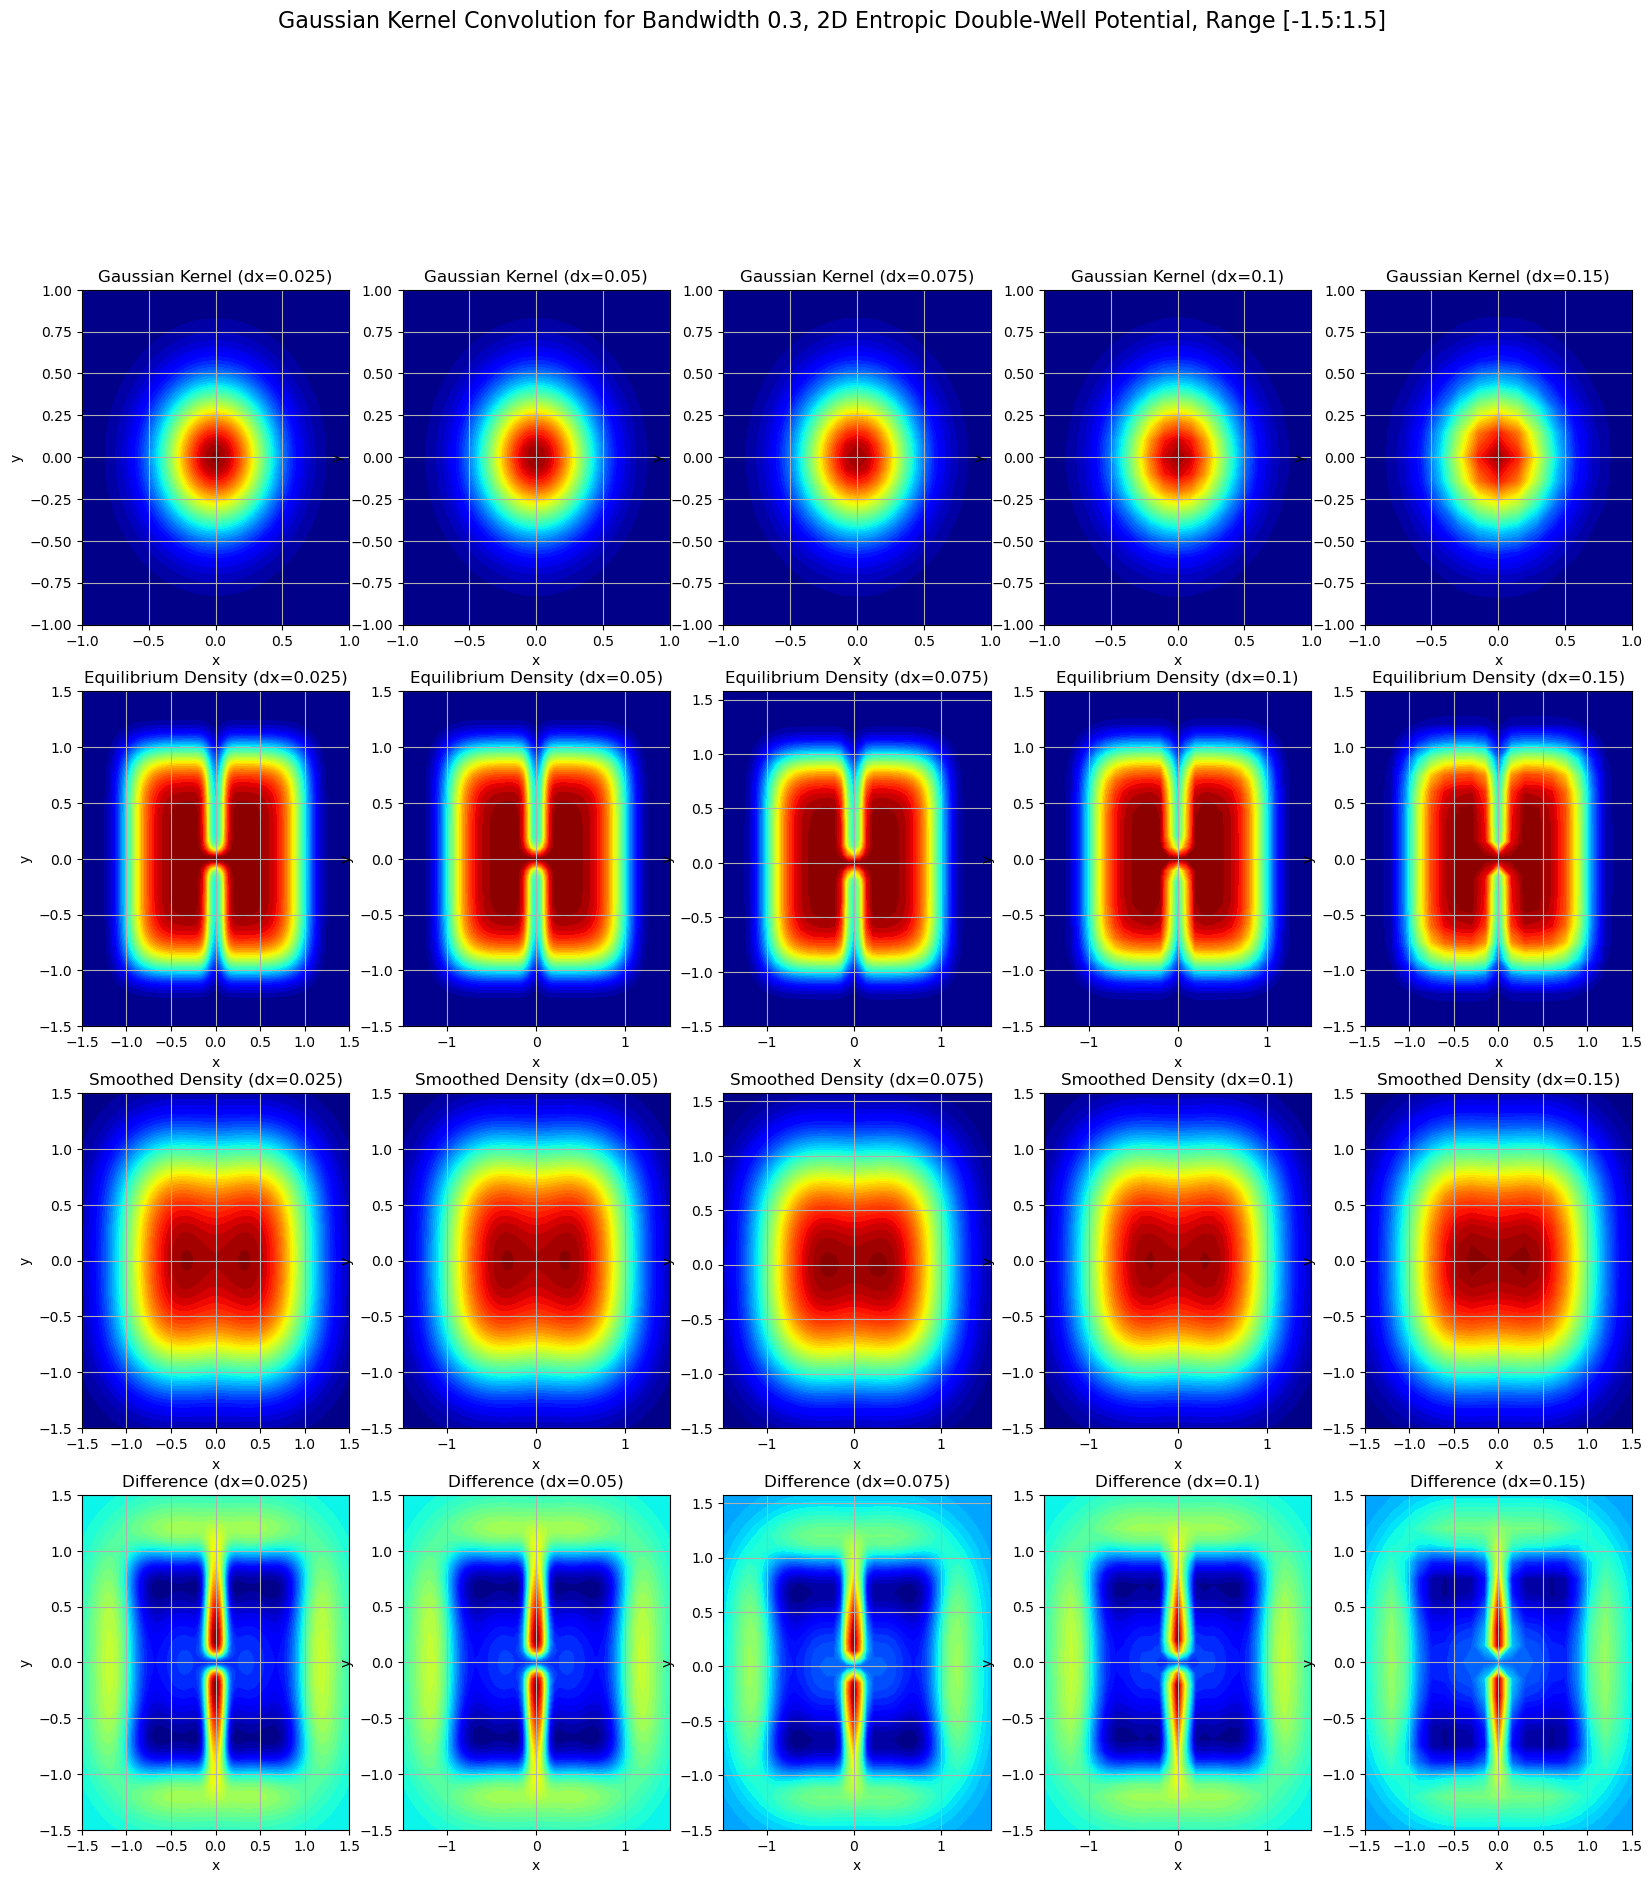

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# 2D Entropic Double-Well Potential Function


def V(x, y, sigma_x=0.1, sigma_y=0.1, a=1.0):
    return a * (x**6 + y**6 + np.exp(-(x/sigma_x)**2) * (1 - np.exp(-(y/sigma_y)**2)))



def gaussian_kernel_2d(x, y, sigma_kernel):
    coeff = 1.0 / (2.0 * np.pi * sigma_kernel**2)
    exponent = -0.5 * (x**2 + y**2) / (sigma_kernel**2)
    return coeff * np.exp(exponent)

def convolve_density_2d(boltz_array, kernel_array, dx, dy):
    """Perform 2D convolution on the density array manually."""
    boltz_array_conv = np.zeros_like(boltz_array)
    kernel_half_x = (kernel_array.shape[0] - 1) // 2
    kernel_half_y = (kernel_array.shape[1] - 1) // 2
    
    
    
     # Iterate over each pixel in the boltz_array
    for i in range(boltz_array.shape[0]):
        for j in range(boltz_array.shape[1]):
            
             # Iterate over each pixel in the kernel
            for m in range(kernel_array.shape[0]):
                for n in range(kernel_array.shape[1]):
                    i_shift = i - kernel_half_x + m
                    j_shift = j - kernel_half_y + n
                    
                    # Check if the shifted position is within the bounds
                    if 0 <= i_shift < boltz_array.shape[0] and 0 <= j_shift < boltz_array.shape[1]:
                        boltz_array_conv[i_shift, j_shift] += boltz_array[i, j] * kernel_array[m, n] * dx * dy
    
    return boltz_array_conv

def plot_results_2d(lattice_spacings, sigma_kernel, x_min, x_max, y_min, y_max):
    num_plots = len(lattice_spacings)
    fig, axs = plt.subplots(4, num_plots, figsize=(20, 20))
    
    
      # Set the figure background color to white
    fig.patch.set_facecolor('white')
    
    # Set the background color of all axes to white
    for ax in axs.flat:
        ax.set_facecolor('white')

    for i, dx in enumerate(lattice_spacings):
        dy = dx  # Assuming square grid
        x = np.arange(x_min, x_max + dx, dx)
        y = np.arange(y_min, y_max + dy, dy)
        X, Y = np.meshgrid(x, y)
        potential_array = V(X, Y)
        boltz_array = np.exp(-potential_array)
        
        # Normalize the Boltzmann density
        boltz_array /= np.trapz(np.trapz(boltz_array, y, axis=0), x, axis=0)
        
        # Kernel and its convolution
        kernel_size = int(5 * sigma_kernel)  # Approximate size
        npoints_kernel_x = int((kernel_size - 0.1 * dx) / dx) + 1
        npoints_kernel_x = 2 * npoints_kernel_x + 1  # Ensure odd number
        kernel_x = np.linspace(-kernel_size, kernel_size, npoints_kernel_x)
        
        npoints_kernel_y = int((kernel_size - 0.1 * dy) / dy) + 1
        npoints_kernel_y = 2 * npoints_kernel_y + 1  # Ensure odd number
        kernel_y = np.linspace(-kernel_size, kernel_size, npoints_kernel_y)
        
        Kernel_X, Kernel_Y = np.meshgrid(kernel_x, kernel_y)
        kernel_array = gaussian_kernel_2d(Kernel_X, Kernel_Y, sigma_kernel)
        
        # Normalize the kernel using trapezium rule
        kernel_integral = np.trapz(np.trapz(kernel_array, kernel_y, axis=0), kernel_x, axis=0)
        kernel_array /= kernel_integral
        
        # Print the integral of the kernel to check if it is equal to one
        print(f'Integral of the Gaussian kernel for dx={dx}: {np.trapz(np.trapz(kernel_array, kernel_y, axis=0), kernel_x, axis=0)}')
        
        boltz_array_conv = convolve_density_2d(boltz_array, kernel_array, dx, dy)
        
        # Calculate potential from convolved density
        with np.errstate(divide='ignore'):
            potential_array_conv = -np.log(boltz_array_conv)
        
        # Plot Gaussian Kernel
        axs[0, i].contourf(Kernel_X, Kernel_Y, kernel_array, levels=50, cmap='jet')
        axs[0, i].set_xlabel('x')
        axs[0, i].set_ylabel('y')
        axs[0, i].set_title(f'Gaussian Kernel (dx={dx})')
        axs[0, i].grid(True)
        
        # Plot Equilibrium Density
        axs[1, i].contourf(X, Y, boltz_array, levels=50, cmap='jet')
        axs[1, i].set_xlabel('x')
        axs[1, i].set_ylabel('y')
        axs[1, i].set_title(f'Equilibrium Density (dx={dx})')
        axs[1, i].grid(True)
        
        # Plot Smoothed Density
        axs[2, i].contourf(X, Y, boltz_array_conv, levels=50, cmap='jet')
        axs[2, i].set_xlabel('x')
        axs[2, i].set_ylabel('y')
        axs[2, i].set_title(f'Smoothed Density (dx={dx})')
        axs[2, i].grid(True)
        
        # Compute and Plot Difference between Densities
        density_difference = boltz_array_conv - boltz_array
        axs[3, i].contourf(X, Y, density_difference, levels=50, cmap='jet')
        axs[3, i].set_xlabel('x')
        axs[3, i].set_ylabel('y')
        axs[3, i].set_title(f'Difference (dx={dx})')
        axs[3, i].grid(True)
        
        
     # Add a main title to the figure     
    fig.suptitle('Gaussian Kernel Convolution for Bandwidth 0.3, 2D Entropic Double-Well Potential, Range [-1.5:1.5]', fontsize=16, y=1.02)
     # Adjust layout and save the plotplt.tight_layout()
    plt.savefig('GK_2d_jet_bwo3.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

if __name__ == "__main__":
    lattice_spacings = [0.025, 0.05, 0.075, 0.1, 0.15]  # Finer lattice spacings for 2D
    sigma_kernel = 0.3  # Fixed bandwidth for Gaussian kernel
    x_min, x_max = -1.5, 1.5  # Range in x direction
    y_min, y_max = -1.5, 1.5  # Range in y direction
    plot_results_2d(lattice_spacings, sigma_kernel, x_min, x_max, y_min, y_max)


Integral of the Gaussian kernel for dx=0.025: 0.9999999999999999
Integral of the Gaussian kernel for dx=0.05: 1.0
Integral of the Gaussian kernel for dx=0.075: 1.0
Integral of the Gaussian kernel for dx=0.1: 1.0
Integral of the Gaussian kernel for dx=0.15: 1.0


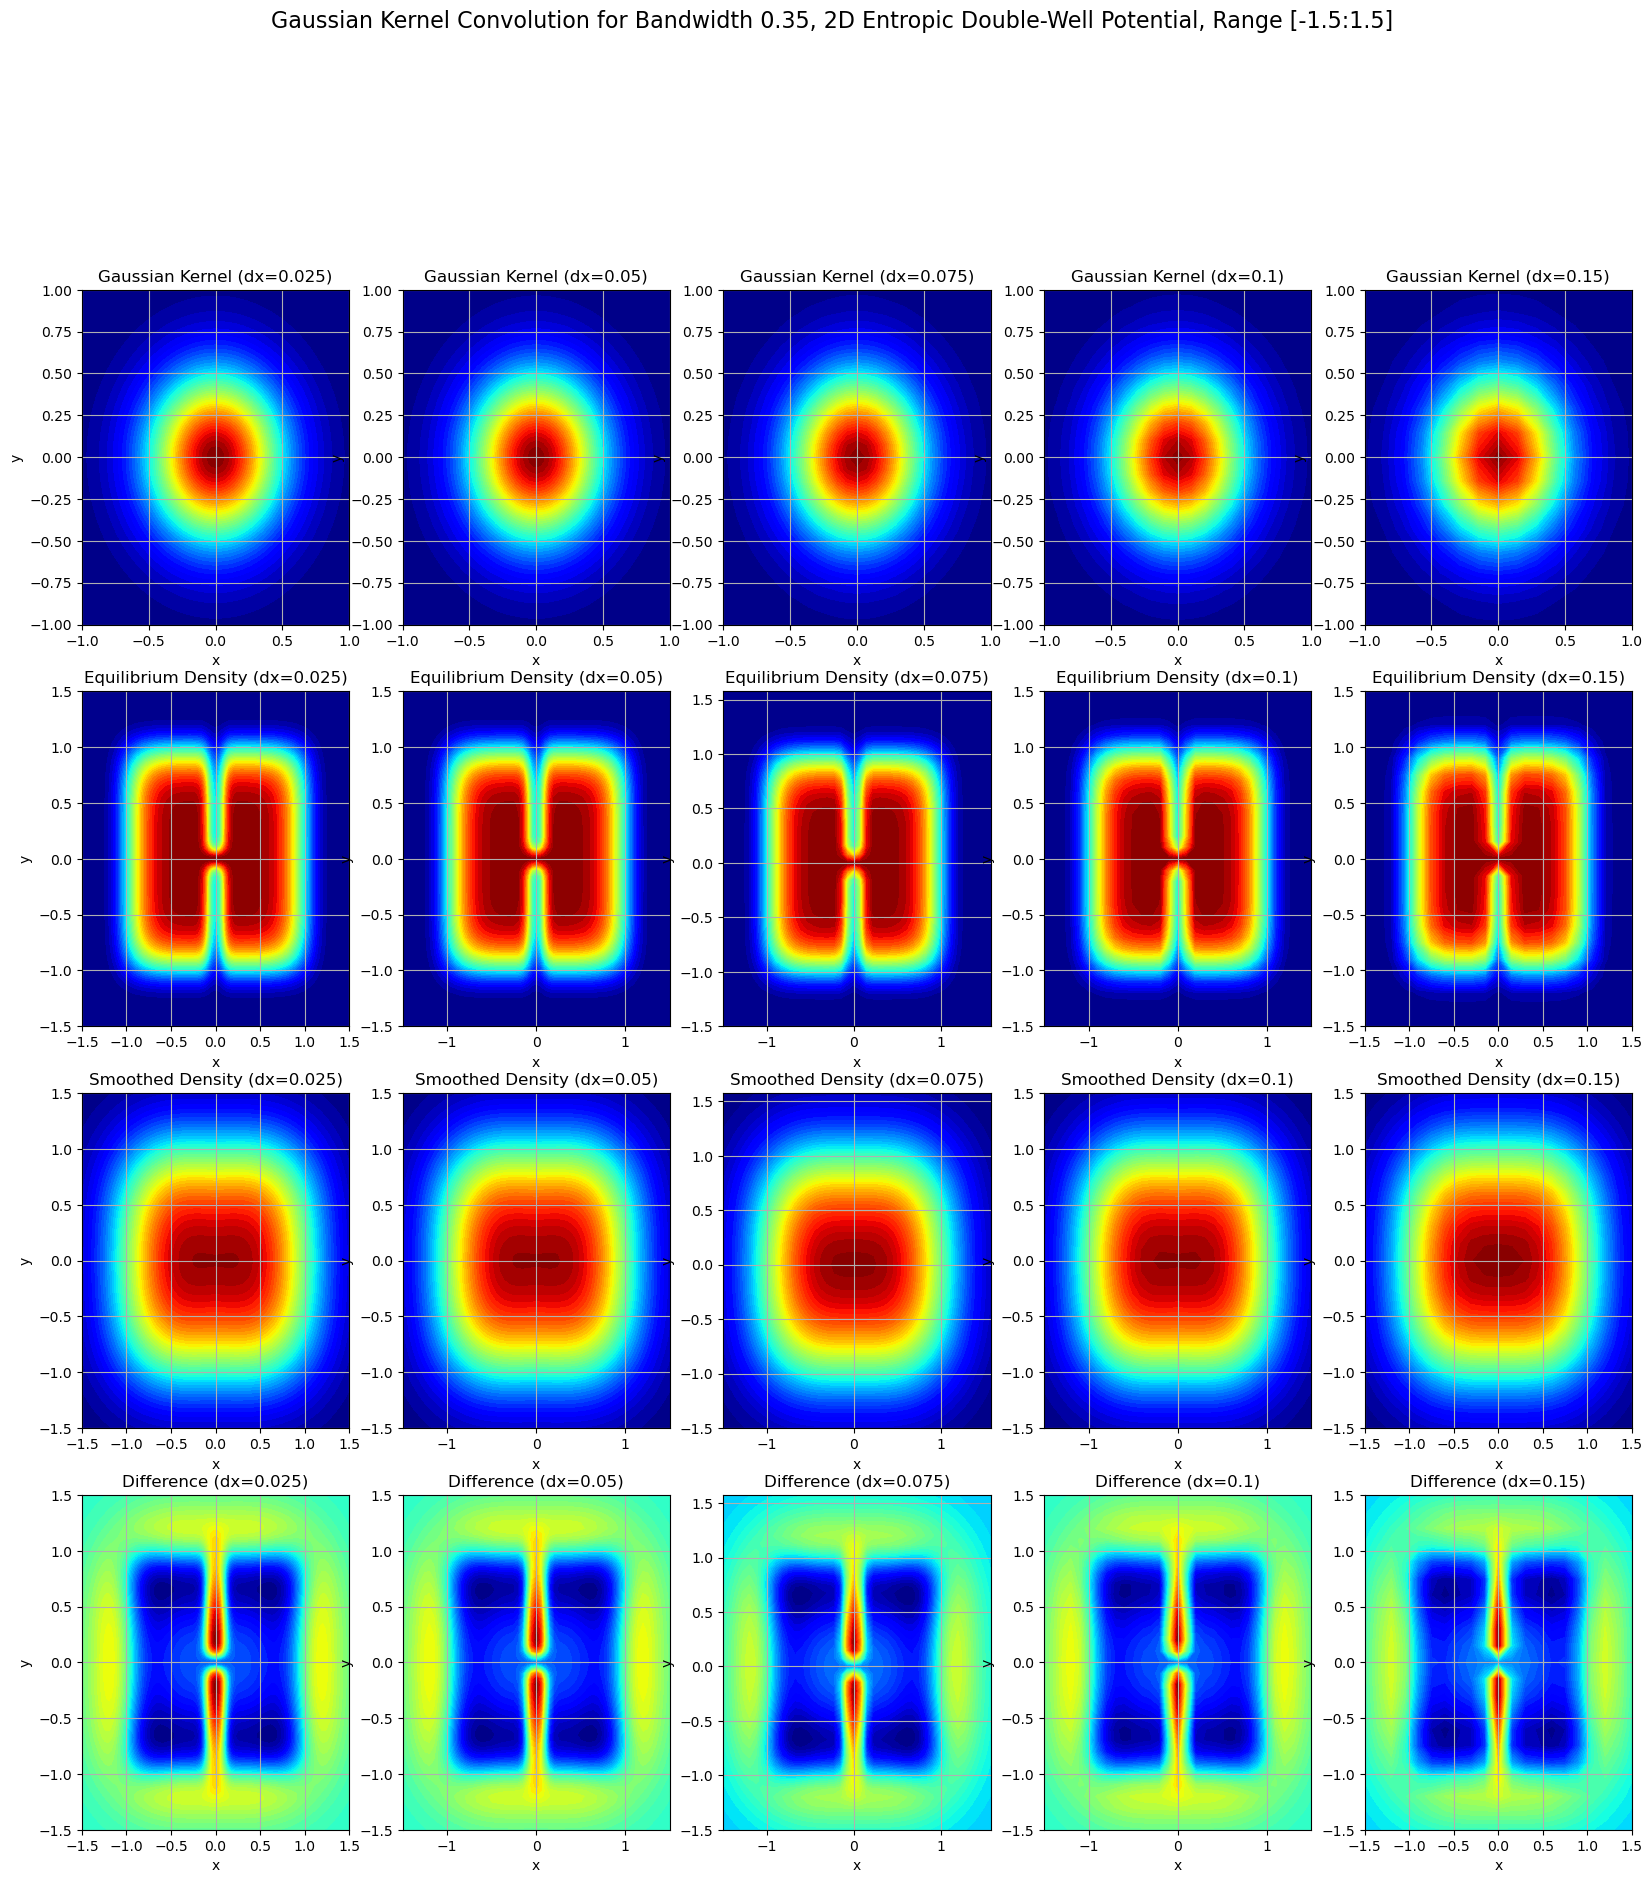

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# 2D Entropic Double-Well Potential Function


def V(x, y, sigma_x=0.1, sigma_y=0.1, a=1.0):
    return a * (x**6 + y**6 + np.exp(-(x/sigma_x)**2) * (1 - np.exp(-(y/sigma_y)**2)))



def gaussian_kernel_2d(x, y, sigma_kernel):
    coeff = 1.0 / (2.0 * np.pi * sigma_kernel**2)
    exponent = -0.5 * (x**2 + y**2) / (sigma_kernel**2)
    return coeff * np.exp(exponent)

def convolve_density_2d(boltz_array, kernel_array, dx, dy):
    """Perform 2D convolution on the density array manually."""
    boltz_array_conv = np.zeros_like(boltz_array)
    kernel_half_x = (kernel_array.shape[0] - 1) // 2
    kernel_half_y = (kernel_array.shape[1] - 1) // 2
    
    
    
     # Iterate over each pixel in the boltz_array
    for i in range(boltz_array.shape[0]):
        for j in range(boltz_array.shape[1]):
            
             # Iterate over each pixel in the kernel
            for m in range(kernel_array.shape[0]):
                for n in range(kernel_array.shape[1]):
                    i_shift = i - kernel_half_x + m
                    j_shift = j - kernel_half_y + n
                    
                    # Check if the shifted position is within the bounds
                    if 0 <= i_shift < boltz_array.shape[0] and 0 <= j_shift < boltz_array.shape[1]:
                        boltz_array_conv[i_shift, j_shift] += boltz_array[i, j] * kernel_array[m, n] * dx * dy
    
    return boltz_array_conv

def plot_results_2d(lattice_spacings, sigma_kernel, x_min, x_max, y_min, y_max):
    num_plots = len(lattice_spacings)
    fig, axs = plt.subplots(4, num_plots, figsize=(20, 20))
    
    
      # Set the figure background color to white
    fig.patch.set_facecolor('white')
    
    # Set the background color of all axes to white
    for ax in axs.flat:
        ax.set_facecolor('white')

    for i, dx in enumerate(lattice_spacings):
        dy = dx  # Assuming square grid
        x = np.arange(x_min, x_max + dx, dx)
        y = np.arange(y_min, y_max + dy, dy)
        X, Y = np.meshgrid(x, y)
        potential_array = V(X, Y)
        boltz_array = np.exp(-potential_array)
        
        # Normalize the Boltzmann density
        boltz_array /= np.trapz(np.trapz(boltz_array, y, axis=0), x, axis=0)
        
        # Kernel and its convolution
        kernel_size = int(5 * sigma_kernel)  # Approximate size
        npoints_kernel_x = int((kernel_size - 0.1 * dx) / dx) + 1
        npoints_kernel_x = 2 * npoints_kernel_x + 1  # Ensure odd number
        kernel_x = np.linspace(-kernel_size, kernel_size, npoints_kernel_x)
        
        npoints_kernel_y = int((kernel_size - 0.1 * dy) / dy) + 1
        npoints_kernel_y = 2 * npoints_kernel_y + 1  # Ensure odd number
        kernel_y = np.linspace(-kernel_size, kernel_size, npoints_kernel_y)
        
        Kernel_X, Kernel_Y = np.meshgrid(kernel_x, kernel_y)
        kernel_array = gaussian_kernel_2d(Kernel_X, Kernel_Y, sigma_kernel)
        
        # Normalize the kernel using trapezium rule
        kernel_integral = np.trapz(np.trapz(kernel_array, kernel_y, axis=0), kernel_x, axis=0)
        kernel_array /= kernel_integral
        
        # Print the integral of the kernel to check if it is equal to one
        print(f'Integral of the Gaussian kernel for dx={dx}: {np.trapz(np.trapz(kernel_array, kernel_y, axis=0), kernel_x, axis=0)}')
        
        boltz_array_conv = convolve_density_2d(boltz_array, kernel_array, dx, dy)
        
        # Calculate potential from convolved density
        with np.errstate(divide='ignore'):
            potential_array_conv = -np.log(boltz_array_conv)
        
        # Plot Gaussian Kernel
        axs[0, i].contourf(Kernel_X, Kernel_Y, kernel_array, levels=50, cmap='jet')
        axs[0, i].set_xlabel('x')
        axs[0, i].set_ylabel('y')
        axs[0, i].set_title(f'Gaussian Kernel (dx={dx})')
        axs[0, i].grid(True)
        
        # Plot Equilibrium Density
        axs[1, i].contourf(X, Y, boltz_array, levels=50, cmap='jet')
        axs[1, i].set_xlabel('x')
        axs[1, i].set_ylabel('y')
        axs[1, i].set_title(f'Equilibrium Density (dx={dx})')
        axs[1, i].grid(True)
        
        # Plot Smoothed Density
        axs[2, i].contourf(X, Y, boltz_array_conv, levels=50, cmap='jet')
        axs[2, i].set_xlabel('x')
        axs[2, i].set_ylabel('y')
        axs[2, i].set_title(f'Smoothed Density (dx={dx})')
        axs[2, i].grid(True)
        
        # Compute and Plot Difference between Densities
        density_difference = boltz_array_conv - boltz_array
        axs[3, i].contourf(X, Y, density_difference, levels=50, cmap='jet')
        axs[3, i].set_xlabel('x')
        axs[3, i].set_ylabel('y')
        axs[3, i].set_title(f'Difference (dx={dx})')
        axs[3, i].grid(True)
        
        
     # Add a main title to the figure     
    fig.suptitle('Gaussian Kernel Convolution for Bandwidth 0.35, 2D Entropic Double-Well Potential, Range [-1.5:1.5]', fontsize=16, y=1.02)
     # Adjust layout and save the plotplt.tight_layout()
    plt.savefig('GK_2d_jet_bwo35.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

if __name__ == "__main__":
    lattice_spacings = [0.025, 0.05, 0.075, 0.1, 0.15]  # Finer lattice spacings for 2D
    sigma_kernel = 0.35  # Fixed bandwidth for Gaussian kernel
    x_min, x_max = -1.5, 1.5  # Range in x direction
    y_min, y_max = -1.5, 1.5  # Range in y direction
    plot_results_2d(lattice_spacings, sigma_kernel, x_min, x_max, y_min, y_max)


Integral of the Gaussian kernel for dx=0.025: 0.9999999999999998
Integral of the Gaussian kernel for dx=0.05: 1.0
Integral of the Gaussian kernel for dx=0.075: 0.9999999999999999
Integral of the Gaussian kernel for dx=0.1: 1.0
Integral of the Gaussian kernel for dx=0.15: 1.0


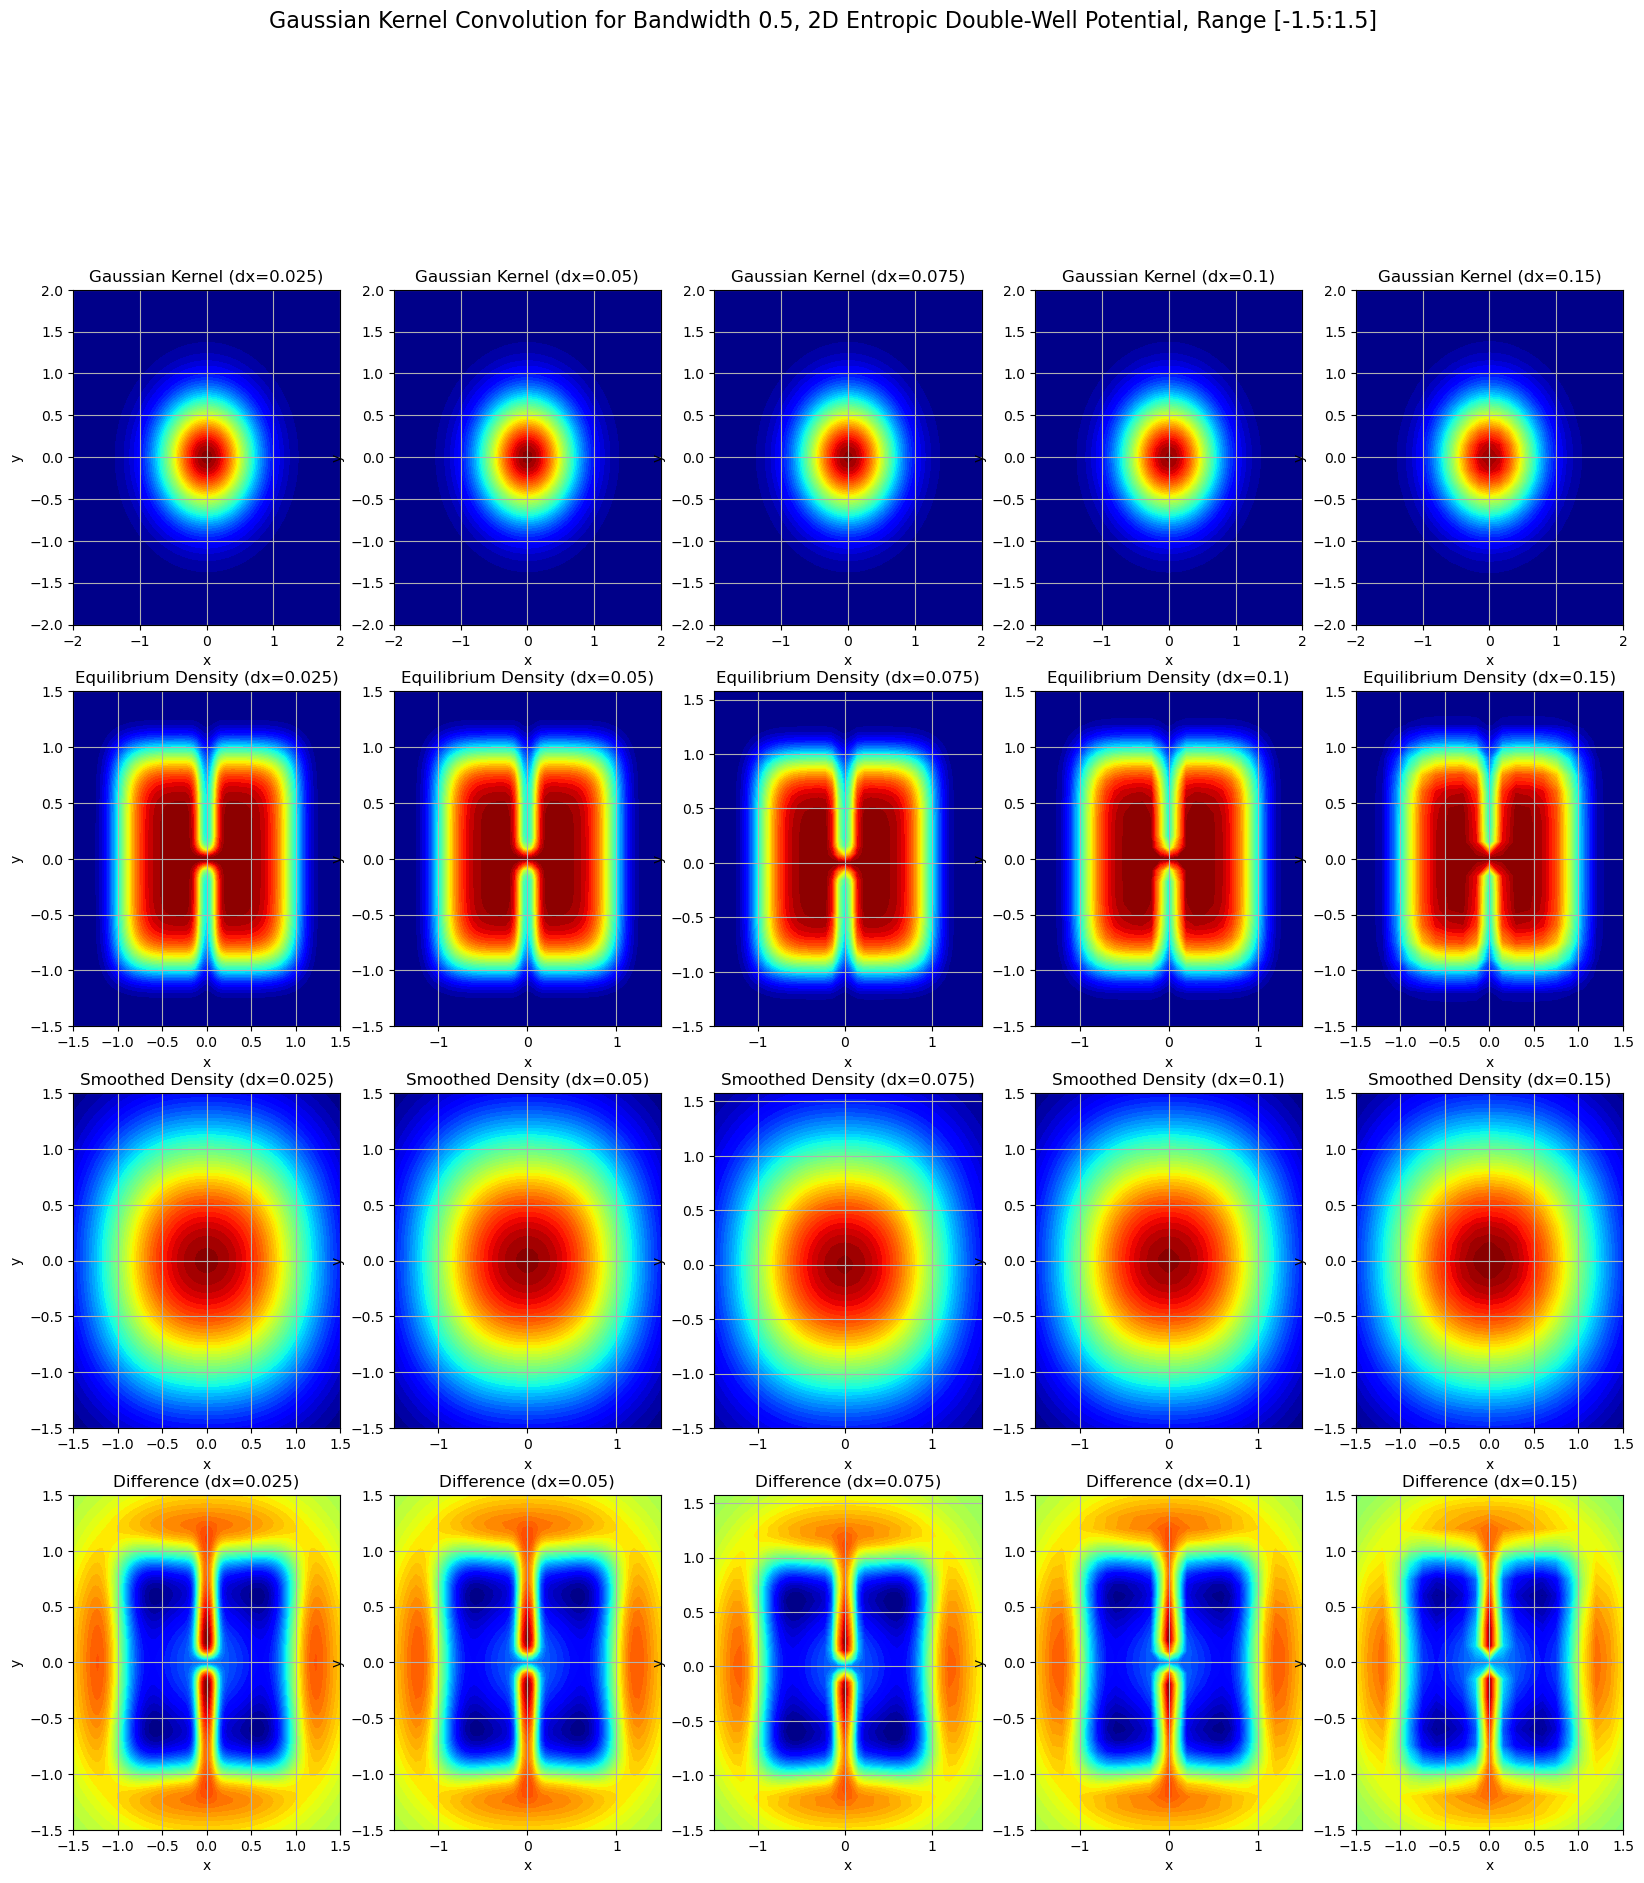

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# 2D Entropic Double-Well Potential Function


def V(x, y, sigma_x=0.1, sigma_y=0.1, a=1.0):
    return a * (x**6 + y**6 + np.exp(-(x/sigma_x)**2) * (1 - np.exp(-(y/sigma_y)**2)))



def gaussian_kernel_2d(x, y, sigma_kernel):
    coeff = 1.0 / (2.0 * np.pi * sigma_kernel**2)
    exponent = -0.5 * (x**2 + y**2) / (sigma_kernel**2)
    return coeff * np.exp(exponent)

def convolve_density_2d(boltz_array, kernel_array, dx, dy):
    """Perform 2D convolution on the density array manually."""
    boltz_array_conv = np.zeros_like(boltz_array)
    kernel_half_x = (kernel_array.shape[0] - 1) // 2
    kernel_half_y = (kernel_array.shape[1] - 1) // 2
    
    
    
     # Iterate over each pixel in the boltz_array
    for i in range(boltz_array.shape[0]):
        for j in range(boltz_array.shape[1]):
            
             # Iterate over each pixel in the kernel
            for m in range(kernel_array.shape[0]):
                for n in range(kernel_array.shape[1]):
                    i_shift = i - kernel_half_x + m
                    j_shift = j - kernel_half_y + n
                    
                    # Check if the shifted position is within the bounds
                    if 0 <= i_shift < boltz_array.shape[0] and 0 <= j_shift < boltz_array.shape[1]:
                        boltz_array_conv[i_shift, j_shift] += boltz_array[i, j] * kernel_array[m, n] * dx * dy
    
    return boltz_array_conv

def plot_results_2d(lattice_spacings, sigma_kernel, x_min, x_max, y_min, y_max):
    num_plots = len(lattice_spacings)
    fig, axs = plt.subplots(4, num_plots, figsize=(20, 20))
    
    
      # Set the figure background color to white
    fig.patch.set_facecolor('white')
    
    # Set the background color of all axes to white
    for ax in axs.flat:
        ax.set_facecolor('white')

    for i, dx in enumerate(lattice_spacings):
        dy = dx  # Assuming square grid
        x = np.arange(x_min, x_max + dx, dx)
        y = np.arange(y_min, y_max + dy, dy)
        X, Y = np.meshgrid(x, y)
        potential_array = V(X, Y)
        boltz_array = np.exp(-potential_array)
        
        # Normalize the Boltzmann density
        boltz_array /= np.trapz(np.trapz(boltz_array, y, axis=0), x, axis=0)
        
        # Kernel and its convolution
        kernel_size = int(5 * sigma_kernel)  # Approximate size
        npoints_kernel_x = int((kernel_size - 0.1 * dx) / dx) + 1
        npoints_kernel_x = 2 * npoints_kernel_x + 1  # Ensure odd number
        kernel_x = np.linspace(-kernel_size, kernel_size, npoints_kernel_x)
        
        npoints_kernel_y = int((kernel_size - 0.1 * dy) / dy) + 1
        npoints_kernel_y = 2 * npoints_kernel_y + 1  # Ensure odd number
        kernel_y = np.linspace(-kernel_size, kernel_size, npoints_kernel_y)
        
        Kernel_X, Kernel_Y = np.meshgrid(kernel_x, kernel_y)
        kernel_array = gaussian_kernel_2d(Kernel_X, Kernel_Y, sigma_kernel)
        
        # Normalize the kernel using trapezium rule
        kernel_integral = np.trapz(np.trapz(kernel_array, kernel_y, axis=0), kernel_x, axis=0)
        kernel_array /= kernel_integral
        
        # Print the integral of the kernel to check if it is equal to one
        print(f'Integral of the Gaussian kernel for dx={dx}: {np.trapz(np.trapz(kernel_array, kernel_y, axis=0), kernel_x, axis=0)}')
        
        boltz_array_conv = convolve_density_2d(boltz_array, kernel_array, dx, dy)
        
        # Calculate potential from convolved density
        with np.errstate(divide='ignore'):
            potential_array_conv = -np.log(boltz_array_conv)
        
        # Plot Gaussian Kernel
        axs[0, i].contourf(Kernel_X, Kernel_Y, kernel_array, levels=50, cmap='jet')
        axs[0, i].set_xlabel('x')
        axs[0, i].set_ylabel('y')
        axs[0, i].set_title(f'Gaussian Kernel (dx={dx})')
        axs[0, i].grid(True)
        
        # Plot Equilibrium Density
        axs[1, i].contourf(X, Y, boltz_array, levels=50, cmap='jet')
        axs[1, i].set_xlabel('x')
        axs[1, i].set_ylabel('y')
        axs[1, i].set_title(f'Equilibrium Density (dx={dx})')
        axs[1, i].grid(True)
        
        # Plot Smoothed Density
        axs[2, i].contourf(X, Y, boltz_array_conv, levels=50, cmap='jet')
        axs[2, i].set_xlabel('x')
        axs[2, i].set_ylabel('y')
        axs[2, i].set_title(f'Smoothed Density (dx={dx})')
        axs[2, i].grid(True)
        
        # Compute and Plot Difference between Densities
        density_difference = boltz_array_conv - boltz_array
        axs[3, i].contourf(X, Y, density_difference, levels=50, cmap='jet')
        axs[3, i].set_xlabel('x')
        axs[3, i].set_ylabel('y')
        axs[3, i].set_title(f'Difference (dx={dx})')
        axs[3, i].grid(True)
        
        
     # Add a main title to the figure     
    fig.suptitle('Gaussian Kernel Convolution for Bandwidth 0.5, 2D Entropic Double-Well Potential, Range [-1.5:1.5]', fontsize=16, y=1.02)
     # Adjust layout and save the plotplt.tight_layout()
    plt.savefig('GK_2d_jet_bwo5.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

if __name__ == "__main__":
    lattice_spacings = [0.025, 0.05, 0.075, 0.1, 0.15]  # Finer lattice spacings for 2D
    sigma_kernel = 0.5  # Fixed bandwidth for Gaussian kernel
    x_min, x_max = -1.5, 1.5  # Range in x direction
    y_min, y_max = -1.5, 1.5  # Range in y direction
    plot_results_2d(lattice_spacings, sigma_kernel, x_min, x_max, y_min, y_max)
